In [8]:
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from skimage.color import rgb2gray

import tifffile as TIFF
from matplotlib import cm
from skimage import measure

import PyPlaque
from PyPlaque.experiment import ExperimentFluorescencePlaque
from PyPlaque.phenotypes import Plaque, FluorescencePlaque
from PyPlaque.specimen import (PlaquesImageGray, PlaquesImageRGB, PlaquesMask, PlaquesWell,
                                PlateImage)
from PyPlaque.utils import centroid, check_numbers, fixed_threshold, stitch_wells, get_plaque_mask, \
      getAllPlaqueRegions, remove_background, remove_artifacts, PlaqueImageReadout


In [9]:
# Here we will pick some random rows from the CSV of matlab results and compare with results from PyPlaque

matlab_results_image = pd.read_csv("../../data/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/200601-zplate-g2_ImageData.csv", header = 0)
matlab_results_object = pd.read_csv("../../data/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/200601-zplate-g2_ObjectData.csv", header = 0)


FileNotFoundError: [Errno 2] No such file or directory: '../../data/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/200601-zplate-g2_ImageData.csv'

In [3]:
import scipy.io
mat = scipy.io.loadmat('../../data/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/23_09_14_parameters.mat')


In [24]:
# For plaque channel
params_w2 = mat['parameters'][0][0][2][0]
params_w2_names = list(params_w2.dtype.fields.keys())

params_w2_dict = dict()

for i, p in enumerate(params_w2.tolist()[0]):
  if params_w2_names[i] == 'selectedChannel':
    params_w2_dict[params_w2_names[i]] = p[0]
  else:
    params_w2_dict[params_w2_names[i]] = p[0][0]
  print(f'{params_w2_names[i]}:{p}')


selectedChannel:['w2']
virusThreshold:[[0.032]]
minPlaqueArea:[[2000]]
plaqueConnectivity:[[6]]
minCellArea:[[80]]
maxCellArea:[[90]]
finePlaqueDetectionFlag:[[1]]
plaqueGaussianFilterSize:[[200]]
plaqueGaussianFilterSigma:[[100]]
peakRegionSize:[[50]]


In [25]:
params_w2_dict


{'selectedChannel': 'w2',
 'virusThreshold': 0.032,
 'minPlaqueArea': 2000,
 'plaqueConnectivity': 6,
 'minCellArea': 80,
 'maxCellArea': 90,
 'finePlaqueDetectionFlag': 1,
 'plaqueGaussianFilterSize': 200,
 'plaqueGaussianFilterSigma': 100,
 'peakRegionSize': 50}

In [13]:
mat


{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Sep 14 02:07:51 2023',
 '__version__': '1.0',
 '__globals__': [],
 'parameters': array([[(array([[(array([[0]], dtype=uint8), array([[0]], dtype=uint8), array([[1]], dtype=uint8), array([[1]], dtype=uint8), array(['E:\\PLAQUE\\data\\200601-zplate-g2\\2020-06-03\\2072'],
                       dtype='<U47'), array(['(?<wellName>[A-Z][0-9]*)_s1_(?<channelName>w[0-9]*).tif'],
                       dtype='<U55'), array(['200601-zplate-g2'], dtype='<U16'), array(['E:\\PLAQUE\\data\\results'], dtype='<U22'))                                                         ]],
               dtype=[('stitchFlag', 'O'), ('maskFlag', 'O'), ('nucleiFlag', 'O'), ('virusFlag', 'O'), ('processingFolder', 'O'), ('fileNamePattern', 'O'), ('plateName', 'O'), ('resultOutputFolder', 'O')]), array([[(array([[0.5]]), array(['w1'], dtype='<U2'), array(['manualThresholding'], dtype='<U18'), array([[0.037]]), array([[80]], dtype=uint8), array([

In [59]:
# For nuclei channel
params_w1 = mat['parameters'][0][0][1][0]
params_w1_names = list(params_w1.dtype.fields.keys())

params_w1_dict = dict()

for i, p in enumerate(params_w1.tolist()[0]):
  if params_w1_names[i] == 'selectedChannel' or 'selectedThresholdingMethod':
    params_w1_dict[params_w1_names[i]] = p[0]
  else:
    params_w1_dict[params_w1_names[i]] = float(p[0][0])

  print(f'{params_w1_names[i]}:{p[0][0]}')


artifactThreshold:0.5
selectedChannel:w
selectedThresholdingMethod:m
manualThreshold:0.037
minCellArea:80
maxCellArea:90
illuminationCorrectionFlag:0


In [60]:
params_w1_dict


{'artifactThreshold': array([0.5]),
 'selectedChannel': 'w1',
 'selectedThresholdingMethod': 'manualThresholding',
 'manualThreshold': array([0.037]),
 'minCellArea': array([80], dtype=uint8),
 'maxCellArea': array([90], dtype=uint8),
 'illuminationCorrectionFlag': array([0], dtype=uint8)}

In [30]:
matlab_results_image.head()


,NucleiImageName,wellRow,wellCollumn,maxNucleiIntensity,totalNucleiIntensity,meanNucleiIntensity,numberOfNuclei,VirusImageName,maxVirusIntensity,totalVirusIntensity,meanVirusIntensity,numberOfPlaques,numberOfInfectedNuclei
0,200601-zplate-g2_A01_s1_w1.tif,A,1,32308,9286469919,2214.066963,12953,200601-zplate-g2_A01_s1_w2.tif,37322,7327763701,1747.075010,32,1730
1,200601-zplate-g2_A02_s1_w1.tif,A,2,44135,9155474320,2182.835178,12905,200601-zplate-g2_A02_s1_w2.tif,45051,7505195868,1789.378135,30,1632
2,200601-zplate-g2_A03_s1_w1.tif,A,3,39825,9249109411,2205.159524,12944,200601-zplate-g2_A03_s1_w2.tif,31160,7630521258,1819.258036,41,2124
3,200601-zplate-g2_A04_s1_w1.tif,A,4,32732,9107313173,2171.352666,12830,200601-zplate-g2_A04_s1_w2.tif,53822,7526026914,1794.344643,29,1791
4,200601-zplate-g2_A05_s1_w1.tif,A,5,65535,9163849879,2184.832067,12394,200601-zplate-g2_A05_s1_w2.tif,51669,7437289993,1773.188112,28,1657


In [31]:
matlab_results_object.head()


,Area,Centroid_1,Centroid_2,BoundingBox_1,BoundingBox_2,BoundingBox_3,BoundingBox_4,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Roundness,numberOfPeaks,numberOfNucleiInPlaque,numberOfInfectedNucleiInPlaque,wellRow,wellCollumn,maxIntensityGFP,totalIntensityGFP,meanIntensity
0,7875,159.381460,391.374857,101.5,311.5,118,150,147.367646,105.891989,0.695469,12010,0.903621,1,49,43,A,1,6756,39932172,2256.054915
1,2660,346.100752,1048.833083,290.5,1010.5,145,88,124.674397,64.299545,0.856745,8140,0.781274,1,27,22,A,1,9554,25677254,2012.323981
2,3785,370.363276,348.663144,332.5,309.5,80,77,80.530378,63.163171,0.620332,4467,0.954889,1,20,20,A,1,6256,16998702,2759.529545
3,6552,444.012210,1716.326465,384.5,1650.5,120,132,134.721614,71.944665,0.845469,9226,0.811868,1,29,25,A,1,13637,41453406,2617.007955
4,2883,449.473118,764.695803,395.5,727.5,88,88,85.257718,55.990305,0.754136,4883,0.854728,1,21,14,A,1,9431,20010399,2583.987474


In [32]:
channel_1_identifier = 'w1'
channel_2_identifier = 'w2'


In [33]:
# Sampling a bunch of rows from the two datasets
matlab_results_image_w2 = matlab_results_image.loc[matlab_results_image['VirusImageName'].str. \
                                                   contains(channel_2_identifier, case=True)]
print(matlab_results_image_w2.shape)
sample_matlab_results_image_w2 = matlab_results_image_w2.sample(n=20, replace=False, random_state=1)
print(sample_matlab_results_image_w2.shape)


(384, 13)
(20, 13)


In [34]:
#Now we will try to find the corresponding images and process them
#For images it is easy since we only need to indentify the well which is easy from the image name
#itself, for objects it is a bit difficult since we need to lookup and match the centroid

#loading multiple plates and plate masks as an experiment
exp = ExperimentFluorescencePlaque('../../data/samples_fluorescent_plaques/images',
                                   '../../data/samples_fluorescent_plaques/masks')

#In this case the individual plates are of 384 well plates for fluorescence plaques and
#their corresponding mask directories
plate_dirs, plate_mask_dirs = exp.get_individual_plates()

print(plate_dirs, plate_mask_dirs)

print(exp.get_number_of_plates())
#This number is accurate but we are choosing to ignore other plates other than just one


['200601-zplate-g2', '200528-zplate-g1'] ['200601-zplate-g2', '200528-zplate-g1']
2


In [35]:
params_w2_dict


{'selectedChannel': 'w2',
 'virusThreshold': 0.032,
 'minPlaqueArea': 2000,
 'plaqueConnectivity': 6,
 'minCellArea': 80,
 'maxCellArea': 90,
 'finePlaqueDetectionFlag': 1,
 'plaqueGaussianFilterSize': 200,
 'plaqueGaussianFilterSigma': 100,
 'peakRegionSize': 50}

In [64]:
image_bits = 16
params_w2 = {
    'min_plaque_area': params_w2_dict['minPlaqueArea'],
    'virus_threshold': params_w2_dict['virusThreshold'],
    'plaque_connectivity': params_w2_dict['plaqueConnectivity'],
    'fine_plaque_detection_flag': True if params_w2_dict['finePlaqueDetectionFlag']==1 else False,
    'plaque_gaussian_filter_size': params_w2_dict['plaqueGaussianFilterSize'],
    'plaque_gaussian_filter_sigma': params_w2_dict['plaqueGaussianFilterSigma'],
    'peak_region_size': params_w2_dict['peakRegionSize'],
    'minCellArea': params_w1_dict['minCellArea'][0],
    'maxCellArea': params_w1_dict['maxCellArea'][0]
}

plate_dict_w2 = {}

d = plate_dirs[0]

i = 1
plate_dict_w2[d] = {}
plate_dict_w2[d]['img'] = {}
plate_dict_w2[d]['mask'] = {}
plate_dict_w2[d]['image_name'] = {}
image_files_for_comparison = list(sample_matlab_results_image_w2['VirusImageName'])
image_files_for_comparison = [os.path.join(exp.plate_folder,d,'2020-06-03','2072',f)
                                for f in image_files_for_comparison]
for f in image_files_for_comparison:
    plate_dict_w2[d]['img'][i] = TIFF.imread(f)
    plate_dict_w2[d]['image_name'][i] = f
    plate_dict_w2[d]['mask'][i],_ = get_plaque_mask(plate_dict_w2[d]['img'][i],params_w2)
    i+=1


[[1278  971]
 [1401  799]
 [1477  220]
 [1675  121]
 [1479 1150]
 [1005  235]
 [ 289  840]
 [1089  617]
 [ 175  846]
 [1097 1176]
 [ 440 1048]
 [1033 1905]
 [1379 1912]
 [1223  587]
 [ 451  712]
 [1273  497]
 [1278 1208]
 [  45 1202]
 [1314 1103]
 [ 119  808]
 [1121  830]
 [1403  184]
 [1224 1254]
 [1428 1491]
 [ 925  776]
 [1040  996]
 [1820 1209]
 [1333 1229]
 [ 897  261]
 [1289  697]
 [1013  642]
 [ 866  643]
 [1705  486]
 [ 908 1375]
 [1356  460]
 [1285  402]
 [ 711 1042]
 [ 799 1407]
 [ 884  891]
 [ 175  732]
 [1360 1504]
 [1165 1433]
 [ 866 1132]
 [1532  697]
 [ 968  937]
 [1053 1340]
 [1347  988]
 [ 926  546]
 [ 958  860]
 [1191 1137]
 [1554  639]
 [1115 1309]
 [1030 1186]
 [1328  331]
 [1468 1016]
 [1008  166]
 [ 657  969]
 [ 733  976]
 [1457  647]
 [1086 1447]
 [1306  856]
 [1040  742]
 [1089 1239]
 [1178 1771]
 [ 759  883]
 [1168  687]
 [1622  542]
 [1035  460]
 [ 801  711]
 [ 597 1173]
 [ 847 1709]
 [ 968 1070]
 [1498  881]
 [ 957 1186]
 [1138 1046]
 [1228 1410]
 [1399  385]

# VA PLAYGROUND START

In [20]:
%load_ext autoreload
%autoreload 2

import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from skimage.color import rgb2gray

import tifffile as TIFF
from matplotlib import cm
from skimage import measure
from skimage import io
import PyPlaque
from PyPlaque.experiment import ExperimentFluorescencePlaque
from PyPlaque.phenotypes import Plaque, FluorescencePlaque
from PyPlaque.specimen import (PlaquesImageGray, PlaquesImageRGB, PlaquesMask, PlaquesWell,
                                PlateImage)
from PyPlaque.utils import centroid, check_numbers, fixed_threshold, stitch_wells, get_plaque_mask, \
      getAllPlaqueRegions, remove_background, remove_artifacts, PlaqueImageReadout


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\Vardan\plaque\data\ecc_test\A02_s1_w2.tif
(2048, 2048)
[[727 848]]
1
4906
0.046028852462768555
0


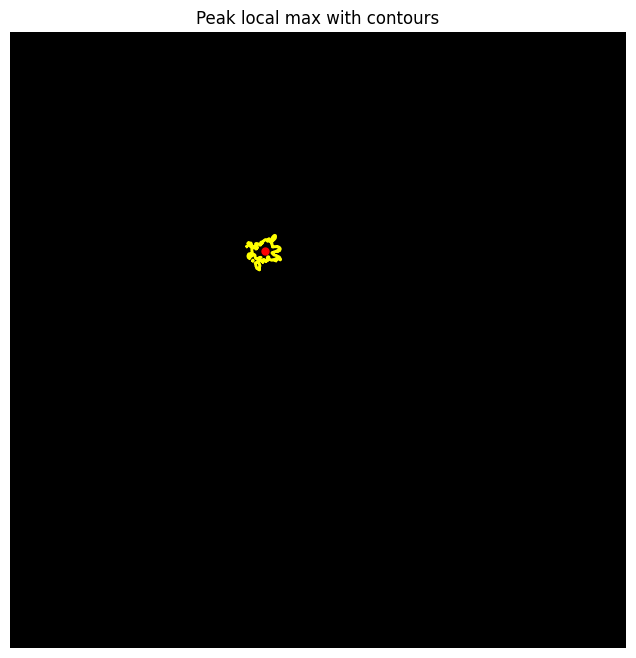

In [61]:
from importlib import reload
reload(PyPlaque)
image_bits = 16
virus_params = {
    'min_plaque_area': 2000,
    'virus_threshold': 0.032 * (2**image_bits - 1),
    #'virus_threshold': 0.03 * (2**image_bits - 1),
    'plaque_connectivity': 6,
    'fine_plaque_detection_flag': True,
    #'plaque_gaussian_filter_size': 150,
    'plaque_gaussian_filter_size': 200,
    'plaque_gaussian_filter_sigma': 100,
    'peak_region_size': 50,
    'minCellArea': 80,
    'maxCellArea': 90,
    'correctionBallRadius': 120
}

plate_dict_w2 = {}

# d = plate_dirs[0]

d=  r'sample_plate'

i = 1
plate_dict_w2[d] = {}
plate_dict_w2[d]['img'] = {}
plate_dict_w2[d]['mask'] = {}
plate_dict_w2[d]['image_name'] = {}
image_files_for_comparison = {r"C:\Users\Vardan\plaque\data\200601-zplate-g2\2020-06-03\2072\200601-zplate-g2_A03_s1_w2.tif"}
# image_files_for_comparison = {r"C:\Users\Vardan\plaque\data\sample_stitched\crop.tif"}

# image_files_for_comparison = {r"E:\PLAQUE\data\sample_stitched\sample_vir_A01_w2.tif"}
# image_files_for_comparison = {r"E:\PLAQUE\data\sample_stitched\dumb_A01_w2.tif"}
# image_files_for_comparison = list(sample_matlab_results_image_w2['VirusImageName'])
# image_files_for_comparison = [os.path.join(exp.plate_folder,d,'2020-06-03','2072',f)
#                                 for f in image_files_for_comparison]
for f in image_files_for_comparison:
    print(f)
    plate_dict_w2[d]['img'][i] = TIFF.imread(f)
    TEST_IM = io.imread(f) 
    # print(plate_dict_w2[d]['img'][i].shape)
    plate_dict_w2[d]['image_name'][i] = f
    # print(plate_dict_w2[d]['image_name'][i])


    # bg, bg_removed_img = remove_background(plate_dict_w2[d]['img'][i],
    #                           radius=virus_params['correctionBallRadius'])
    img = plate_dict_w2[d]['img'][i]

    #plate_dict_w2[d]['mask'][i] = get_plaque_mask(bg_removed_img,virus_params)[0]
    plate_dict_w2[d]['mask'][i],globalPeakCoords = get_plaque_mask(img,virus_params)
    # finalPlqRegImage, globalPeakCoords = get_plaque_mask(img,virus_params)
    print(plate_dict_w2[d]['mask'][i].shape)
    i+=1

input_img = plate_dict_w2[d]['img'][1]
finalPlqRegImage = plate_dict_w2[d]['mask'][1]
print(globalPeakCoords)

plate_name = d
im_name = plate_dict_w2[plate_name] ['image_name'][1].split("\\")[-1]


plq_image_readout = PlaqueImageReadout(nuclei_image_name=im_name,
                            plaque_image_name=im_name,
                            nuclei_image=np.array(plate_dict_w2[plate_name]['img'][1]),
                            plaque_image=np.array(plate_dict_w2[plate_name]['img'][1]),
                            nuclei_mask=np.array(plate_dict_w2[plate_name]['mask'][1]),
                            plaque_mask=np.array(plate_dict_w2[plate_name]['mask'][1]),
                            virus_params = virus_params)

print(plq_image_readout.get_plaque_count())
print(plq_image_readout.get_lesion_area())
print(plq_image_readout.get_mean_plaque_intensity())


print(np.min(TEST_IM))
area_plq  = plq_image_readout.get_plaque_objects()
# print(area_plq[0].area_filled)
# print(np.sum(input_img)/255)


fig, ax = plt.subplots(figsize=(8, 8))

# Display inputImage with custom colormap and intensity range
ax.imshow(input_img, cmap=plt.cm.gray, vmin=0, vmax=6000, alpha=1)
# ax.imshow(finalPlqRegImage, cmap=plt.cm.gray)

# Find contours in finalPlqRegImage
contours = measure.find_contours(finalPlqRegImage)

# Plot contours with random colors
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2,color='yellow')

ax.plot(globalPeakCoords[:, 1], globalPeakCoords[:, 0], 'r.', markersize=10)
ax.axis('off')

ax.set_title('Peak local max with contours')
# plt.savefig("../../../manuscript/figs/fp_plaque_mask_outline.png", bbox_inches='tight')
plt.show()




In [67]:
plq_objects = plq_image_readout.get_plaque_objects()
print(len(plq_objects))

plq_object_readout = plq_image_readout.call_plaque_object_readout(plq_objects[0],
                                                                      virus_params)

print(plq_object_readout.get_centroid())
print(plq_object_readout.get_area())
print(plq_object_readout.get_eccentricity())
print(plq_object_readout.get_major_minor_axis_length())
print(plq_object_readout.roundness())


1
(728.2910829441851, 846.2297086946853)
4549
0.7179100928751599
(98.21758924782444, 68.37278334588824)
0.6732317805923692


In [46]:
from  PIL import Image

img = Image.open(r"C:\Users\Vardan\plaque\data\200601-zplate-g2\2020-06-03\2072\200601-zplate-g2_E10_s1_w2.tif")  # Replace with your image path

# Convert image to a numpy array
img_array = np.array(img)

list_of_lists = img_array.tolist()

# Calculate the sum of all elements in the nested list using a nested loop
total_sum = sum(sum(inner_list) for inner_list in list_of_lists)

print(f"The sum of all elements is: {total_sum}")

# Calculate integrated intensity
integrated_intensity = img_array.sum()

print(f"The integrated intensity of the image is: {integrated_intensity}")
print(img_array[0][0])


The sum of all elements is: 7109193266
The integrated intensity of the image is: 2814225970
1195


# VA PLAYGROUND END

In [65]:
matlab_results_image.loc[(matlab_results_image['wellRow']=='C')&(matlab_results_image['wellCollumn']==15)]


,NucleiImageName,wellRow,wellCollumn,maxNucleiIntensity,totalNucleiIntensity,meanNucleiIntensity,numberOfNuclei,VirusImageName,maxVirusIntensity,totalVirusIntensity,meanVirusIntensity,numberOfPlaques,numberOfInfectedNuclei
62,200601-zplate-g2_C15_s1_w1.tif,C,15,65535,8789265206,2095.524122,11653,200601-zplate-g2_C15_s1_w2.tif,10440,6649741714,1585.421971,1,87


../../data/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/2072/200601-zplate-g2_C15_s1_w2.tif


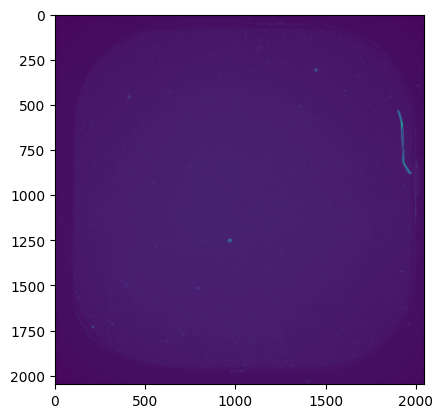

In [66]:
print(plate_dict_w2['200601-zplate-g2']['image_name'][4])
plt.imshow(plate_dict_w2['200601-zplate-g2']['img'][4])


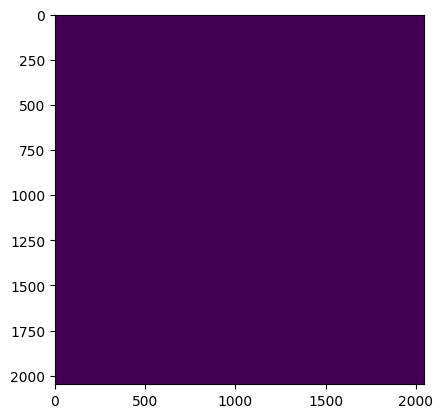

In [14]:
plt.imshow(plate_dict_w2['200601-zplate-g2']['mask'][4])


In [67]:
img_list_w2 = list(plate_dict_w2[plate_dirs[0]]['img'].values())
len(img_list_w2)


20

In [68]:
params_w1_dict


{'artifactThreshold': array([0.5]),
 'selectedChannel': 'w1',
 'selectedThresholdingMethod': 'manualThresholding',
 'manualThreshold': array([0.037]),
 'minCellArea': array([80], dtype=uint8),
 'maxCellArea': array([90], dtype=uint8),
 'illuminationCorrectionFlag': array([0], dtype=uint8)}

In [70]:
image_bits = 16
params_w1 = {
    'selected_thresholding_method': params_w1_dict['selectedThresholdingMethod'],
    'manual_threshold': params_w1_dict['manualThreshold'][0],
    'artifact_threshold': params_w1_dict['artifactThreshold'][0],
    'minCellArea': params_w1_dict['minCellArea'][0],
    'maxCellArea': params_w1_dict['maxCellArea'][0],
    'illuminationCorrectionFlag': True if params_w1_dict['illuminationCorrectionFlag'] == 0 else False,
    'correctionBallRadius': 120
}


plate_dict_w1 = {}

d = plate_dirs[0]

i = 1
plate_dict_w1[d] = {}
plate_dict_w1[d]['img'] = {}
plate_dict_w1[d]['mask'] = {}
plate_dict_w1[d]['image_name'] = {}
image_files_for_comparison = list(sample_matlab_results_image_w2['NucleiImageName'])
image_files_for_comparison = [os.path.join(exp.plate_folder,d,'2020-06-03','2072',f)
                                for f in image_files_for_comparison]
for f in image_files_for_comparison:
    print(f)
    plate_dict_w1[d]['img'][i] = TIFF.imread(f)
    plate_dict_w1[d]['image_name'][i] = f
    artifact_removed_img = remove_artifacts(plate_dict_w1[d]['img'][i],
                                        artifact_threshold=params_w1['artifact_threshold'])
    bg, bg_removed_img = remove_background(artifact_removed_img,
                        radius=params_w1['correctionBallRadius'])
    # regular thresholding
    bg_removed_img[bg_removed_img > params_w1['manual_threshold']] = 1
    bg_removed_img[bg_removed_img <= params_w1['manual_threshold']] = 0
    plate_dict_w1[d]['mask'][i] = bg_removed_img
    i+=1


../../data/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/2072/200601-zplate-g2_K17_s1_w1.tif
new
../../data/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/2072/200601-zplate-g2_E11_s1_w1.tif
new
../../data/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/2072/200601-zplate-g2_F03_s1_w1.tif
new
../../data/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/2072/200601-zplate-g2_C15_s1_w1.tif
new
../../data/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/2072/200601-zplate-g2_H18_s1_w1.tif
new
../../data/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/2072/200601-zplate-g2_L20_s1_w1.tif
new
../../data/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/2072/200601-zplate-g2_F20_s1_w1.tif
new
../../data/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/2072/200601-zplate-g2_D24_s1_w1.tif
new
../../data/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/2072/200601-zp

In [71]:
img_list_w1 = list(plate_dict_w1[plate_dirs[0]]['img'].values())
len(img_list_w1)


20

In [72]:
differences_df_image = pd.DataFrame()
differences_df_image['NucleiImageName'] = sample_matlab_results_image_w2['NucleiImageName']
differences_df_image['VirusImageName'] = sample_matlab_results_image_w2['VirusImageName']


In [73]:
def diff_perc(a,b):
    if a==0 and b==0:
        return 0
    elif a==0:
        return 0
    else:
        return (a-b)*100/a

def diff_fold(a,b):
    if a==0 and b==0:
        return 1
    elif b==0:
        return 0
    else:
        return a/b


In [77]:
#Generating readouts for images as in PyPlaque in Matlab
#Assuming that w1 is the nuclei channel and w2 as the plaque channel


max_nuclei_intensity_diff = []
total_nuclei_intensity_diff = []
mean_nuclei_intensity_diff = []
nuclei_count_diff = []
max_plaque_intensity_diff = []
total_plaque_intensity_diff = []
mean_plaque_intensity_diff = []
# median_plaque_intensity_diff = []
plaque_count_diff = []
infected_nuclei_count_diff = []
# lesion_area_diff = []

for i in range(len(img_list_w2)):
    print(i)
    plq_image_readout = PlaqueImageReadout(nuclei_image_name=plate_dict_w1['200601-zplate-g2']
                                        ['image_name'][i+1].split("/")[-1],
                            plaque_image_name=plate_dict_w2['200601-zplate-g2']['image_name'][i+1].split("/")[-1],
                            nuclei_image=np.array(plate_dict_w1['200601-zplate-g2']['img'][i+1]),
                            plaque_image=np.array(plate_dict_w2['200601-zplate-g2']['img'][i+1]),
                            nuclei_mask=np.array(plate_dict_w1['200601-zplate-g2']['mask'][i+1]),
                            plaque_mask=np.array(plate_dict_w2['200601-zplate-g2']['mask'][i+1]),
                            virus_params = params_w2)

    max_nuclei_intensity_diff.append(diff_fold(
                                    sample_matlab_results_image_w2['maxNucleiIntensity'].iloc[i] ,
                                    plq_image_readout.get_max_nuclei_intensity()))
    total_nuclei_intensity_diff.append(diff_fold(
                                    sample_matlab_results_image_w2['totalNucleiIntensity'].iloc[i] ,
                                    plq_image_readout.get_total_nuclei_intensity()))
    mean_nuclei_intensity_diff.append(diff_fold(
                                    sample_matlab_results_image_w2['meanNucleiIntensity'].iloc[i] ,
                                    plq_image_readout.get_mean_nuclei_intensity()))
    nuclei_count_diff.append(diff_fold(
                                    sample_matlab_results_image_w2['numberOfNuclei'].iloc[i] ,
                                    plq_image_readout.get_nuclei_count()))
    max_plaque_intensity_diff.append(diff_fold(
                                    sample_matlab_results_image_w2['maxVirusIntensity'].iloc[i] ,
                                    plq_image_readout.get_max_plaque_intensity()))
    total_plaque_intensity_diff.append(diff_fold(
                                    sample_matlab_results_image_w2['totalVirusIntensity'].iloc[i] ,
                                    plq_image_readout.get_total_plaque_intensity()))
    mean_plaque_intensity_diff.append(diff_fold(
                                    sample_matlab_results_image_w2['meanVirusIntensity'].iloc[i] ,
                                    plq_image_readout.get_mean_plaque_intensity()))
    # median_plaque_intensity_diff.append(diff_fold(
    #                                 sample_matlab_results_image_w2['medianVirusIntensity'].iloc[i] ,
    #                                 plq_image_readout.get_median_plaque_intensity()))
    plaque_count_diff.append(diff_fold(
                                    sample_matlab_results_image_w2['numberOfPlaques'].iloc[i] ,
                                    plq_image_readout.get_plaque_count()))
    infected_nuclei_count_diff.append(diff_fold(
                                    sample_matlab_results_image_w2['numberOfInfectedNuclei'].iloc[i] ,
                                    plq_image_readout.get_infected_nuclei_count()))
    # lesion_area_diff.append(diff_fold(
    #                                 sample_matlab_results_image_w2['lesionArea'].iloc[i] ,
    #                                 plq_image_readout.get_lesion_area()))



#Maybe it would be good to have a percentage point difference


0
[[1278  971]
 [1401  799]
 [1477  220]
 [1675  121]
 [1479 1150]
 [1005  235]
 [ 289  840]
 [1089  617]
 [ 175  846]
 [1097 1176]
 [ 440 1048]
 [1033 1905]
 [1379 1912]
 [1223  587]
 [ 451  712]
 [1273  497]
 [1278 1208]
 [  45 1202]
 [1314 1103]
 [ 119  808]
 [1121  830]
 [1403  184]
 [1224 1254]
 [1428 1491]
 [ 925  776]
 [1040  996]
 [1820 1209]
 [1333 1229]
 [ 897  261]
 [1289  697]
 [1013  642]
 [ 866  643]
 [1705  486]
 [ 908 1375]
 [1356  460]
 [1285  402]
 [ 711 1042]
 [ 799 1407]
 [ 884  891]
 [ 175  732]
 [1360 1504]
 [1165 1433]
 [ 866 1132]
 [1532  697]
 [ 968  937]
 [1053 1340]
 [1347  988]
 [ 926  546]
 [ 958  860]
 [1191 1137]
 [1554  639]
 [1115 1309]
 [1030 1186]
 [1328  331]
 [1468 1016]
 [1008  166]
 [ 657  969]
 [ 733  976]
 [1457  647]
 [1086 1447]
 [1306  856]
 [1040  742]
 [1089 1239]
 [1178 1771]
 [ 759  883]
 [1168  687]
 [1622  542]
 [1035  460]
 [ 801  711]
 [ 597 1173]
 [ 847 1709]
 [ 968 1070]
 [1498  881]
 [ 957 1186]
 [1138 1046]
 [1228 1410]
 [1399  38

In [78]:
plq_image_readout = PlaqueImageReadout(nuclei_image_name=plate_dict_w1['200601-zplate-g2']
                                        ['image_name'][3+1].split("/")[-1],
                            plaque_image_name=plate_dict_w2['200601-zplate-g2']['image_name'][3+1].split("/")[-1],
                            nuclei_image=np.array(plate_dict_w1['200601-zplate-g2']['img'][3+1]),
                            plaque_image=np.array(plate_dict_w2['200601-zplate-g2']['img'][3+1]),
                            nuclei_mask=np.array(plate_dict_w1['200601-zplate-g2']['mask'][3+1]),
                            plaque_mask=np.array(plate_dict_w2['200601-zplate-g2']['mask'][3+1]),
                            virus_params = params_w2)
print(diff_fold(sample_matlab_results_image_w2['numberOfPlaques'].iloc[3] ,
                plq_image_readout.get_plaque_count()))
print(plq_image_readout.get_row(),plq_image_readout.get_column())
print(sample_matlab_results_image_w2['wellRow'].iloc[3],
      sample_matlab_results_image_w2['wellCollumn'].iloc[3])
print(plq_image_readout.get_plaque_count())
print(sample_matlab_results_image_w2['numberOfPlaques'].iloc[3])


[[ 609 1920]
 [ 835 1936]
 [1252  968]
 [ 703 1924]
 [ 309 1446]
 [1732  210]
 [ 456  412]
 [1425 1918]
 [1518  798]
 [ 509 1353]
 [ 938  541]
 [1499  397]
 [1713  316]
 [1773  708]
 [1091 1996]
 [1261  830]
 [1293  563]
 [ 424 1605]
 [1323 1254]
 [1044  632]
 [1810  621]
 [ 186 1129]
 [1187 1157]
 [1253 1422]
 [ 998 1995]
 [ 310 1100]
 [1408 1164]
 [1143  862]
 [ 902  977]
 [1441  955]
 [1097  694]
 [ 631  925]
 [1199  463]
 [1411  876]
 [ 772 1195]
 [1470 1275]
 [ 823 1083]
 [1109  949]
 [ 949 1085]
 [ 884 1459]
 [1517  673]
 [1058 1269]
 [ 783  777]
 [ 890 1266]
 [1561  443]
 [ 457  815]
 [1201 1514]
 [1018  992]
 [ 885  442]
 [1338 1490]
 [ 765 1381]
 [1396 1040]
 [1401  591]
 [ 823 1262]
 [1608  685]
 [ 455 1855]
 [ 596  687]
 [ 846 1380]
 [ 949  704]
 [ 395 2009]
 [1822 1003]
 [1105 1528]
 [ 804  501]
 [ 847  623]
 [1672  830]
 [ 948  474]
 [1336 1045]
 [ 616  758]
 [ 951 1931]
 [1094 1367]
 [1308  677]
 [1014 1084]
 [1337 1107]
 [1065 1205]
 [ 618 1305]
 [ 825  223]
 [1449  664]

In [79]:
differences_df_image['maxNucleiIntensity'] = max_nuclei_intensity_diff
differences_df_image['totalNucleiIntensity'] = total_nuclei_intensity_diff
differences_df_image['meanNucleiIntensity'] = mean_nuclei_intensity_diff
differences_df_image['numberOfNuclei'] = nuclei_count_diff
differences_df_image['maxVirusIntensity'] = max_plaque_intensity_diff
differences_df_image['totalVirusIntensity'] = total_plaque_intensity_diff
differences_df_image['meanVirusIntensity'] = mean_plaque_intensity_diff
# differences_df_image['medianVirusIntensity'] = median_plaque_intensity_diff
differences_df_image['numberOfPlaques'] = plaque_count_diff
differences_df_image['numberOfInfectedNuclei'] = infected_nuclei_count_diff
# differences_df_image['lesionArea'] = lesion_area_diff


In [80]:
differences_df_image


,NucleiImageName,VirusImageName,maxNucleiIntensity,totalNucleiIntensity,meanNucleiIntensity,numberOfNuclei,maxVirusIntensity,totalVirusIntensity,meanVirusIntensity,numberOfPlaques,numberOfInfectedNuclei
256,200601-zplate-g2_K17_s1_w1.tif,200601-zplate-g2_K17_s1_w2.tif,0,0,0,0,1.0,1.0,1.544252,0.000000,0.001115
106,200601-zplate-g2_E11_s1_w1.tif,200601-zplate-g2_E11_s1_w2.tif,0,0,0,0,1.0,1.0,1.673253,0.131687,0.030109
122,200601-zplate-g2_F03_s1_w1.tif,200601-zplate-g2_F03_s1_w2.tif,0,0,0,0,1.0,1.0,1.667676,0.180995,0.020559
62,200601-zplate-g2_C15_s1_w1.tif,200601-zplate-g2_C15_s1_w2.tif,0,0,0,0,1.0,1.0,1.549020,0.003195,0.001764
185,200601-zplate-g2_H18_s1_w1.tif,200601-zplate-g2_H18_s1_w2.tif,0,0,0,0,1.0,1.0,1.584543,0.000000,0.001480
283,200601-zplate-g2_L20_s1_w1.tif,200601-zplate-g2_L20_s1_w2.tif,0,0,0,0,1.0,1.0,1.558665,0.000000,0.001419
139,200601-zplate-g2_F20_s1_w1.tif,200601-zplate-g2_F20_s1_w2.tif,0,0,0,0,1.0,1.0,1.547047,0.003215,0.001581
95,200601-zplate-g2_D24_s1_w1.tif,200601-zplate-g2_D24_s1_w2.tif,0,0,0,0,1.0,1.0,1.599795,0.000000,0.001561
258,200601-zplate-g2_K19_s1_w1.tif,200601-zplate-g2_K19_s1_w2.tif,0,0,0,0,1.0,1.0,1.548562,0.000000,0.001318
127,200601-zplate-g2_F08_s1_w1.tif,200601-zplate-g2_F08_s1_w2.tif,0,0,0,0,1.0,1.0,1.663859,0.155556,0.029034


In [81]:
iter = len(differences_df_image)
quants = list(differences_df_image.columns)
quants.pop(0)
quants.pop(0)
print(quants)
print(len(quants))
diff_perc_iter_ls  = np.array([list(differences_df_image[quant]) for quant in quants]).flatten()

diff_perc_df = pd.DataFrame({
        "Values": diff_perc_iter_ls,
        "Quant": np.array([[quant]*iter for quant in quants]).flatten()
    })


['maxNucleiIntensity', 'totalNucleiIntensity', 'meanNucleiIntensity', 'numberOfNuclei', 'maxVirusIntensity', 'totalVirusIntensity', 'meanVirusIntensity', 'numberOfPlaques', 'numberOfInfectedNuclei']
9


In [82]:
def barplot_info_loss(diff_df, save_path=None):
    sns.set(font_scale=1.5)
    sns.set_style("ticks")
    sns.barplot(
        x="Quant",
        y="Values",
        data=diff_df,
        errorbar="sd",
        capsize=.2,
        color='black',edgecolor='black'
    ).set(xlabel='Quants', ylabel='Fold Difference')
    plt.xticks(rotation=90)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()
    return


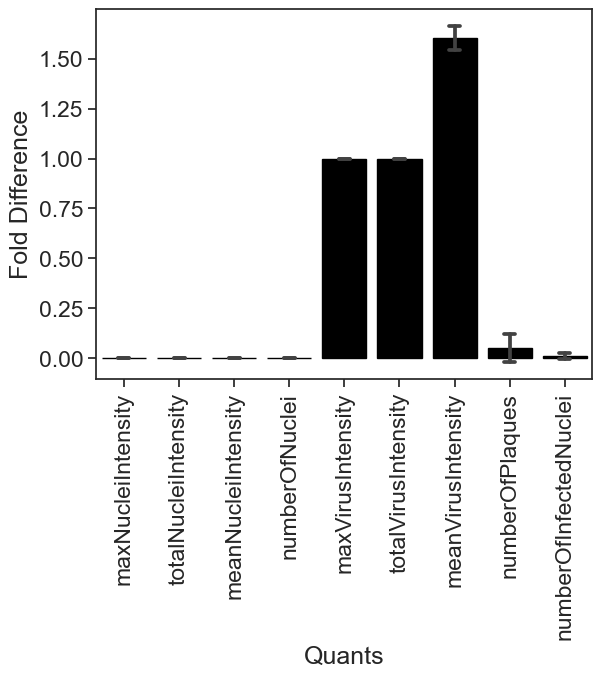

In [83]:
barplot_info_loss(diff_perc_df)


In [84]:
def lookup_objects(df, plq_object_readout):
    filtered_df = df.loc[
        matlab_results_object['wellCollumn'].str.contains(plq_object_readout.get_column(),
                                                          case=True)]

    filtered_df = filtered_df.loc[
        matlab_results_object['wellRow'].str.contains(plq_object_readout.get_row(), case=True)]

    #Y
    df_closest = filtered_df.iloc[(
        filtered_df['Centroid_1']-plq_object_readout.get_centroid()[0]).abs().argsort()[:1]]

    #X
    df_closest = df_closest.iloc[(
        df_closest['Centroid_2']-plq_object_readout.get_centroid()[1]).abs().argsort()[:1]]
    return df_closest


In [85]:
differences_df_object = pd.DataFrame()


In [86]:
matlab_results_object['wellCollumn'] = matlab_results_object['wellCollumn'].apply(str)


In [88]:
#Now for the readouts at the object level
well_row = []
well_column = []
area_diff = []
centroid_1_diff = []
centroid_2_diff = []
bbox_1_diff = []
bbox_2_diff = []
bbox_3_diff = []
bbox_4_diff = []
major_axis_length_diff = []
minor_axis_length_diff = []
eccentricity_diff = []
convex_area_diff = []
roundness_diff = []
peak_counts_diff = []
nuclei_in_plaque_diff = []
infected_nuclei_in_plaque_diff = []
max_intensity_GFP_diff = []
total_intensity_GFP_diff = []
mean_intensity_GFP_diff = []

for i in range(len(img_list_w2)):
    print(i)
    plq_image_readout = PlaqueImageReadout(nuclei_image_name=plate_dict_w1['200601-zplate-g2']
                                        ['image_name'][i+1].split("/")[-1],
                            plaque_image_name=plate_dict_w2['200601-zplate-g2']['image_name'][i+1].split("/")[-1],
                            nuclei_image=np.array(plate_dict_w1['200601-zplate-g2']['img'][i+1]),
                            plaque_image=np.array(plate_dict_w2['200601-zplate-g2']['img'][i+1]),
                            nuclei_mask=np.array(plate_dict_w1['200601-zplate-g2']['mask'][i+1]),
                            plaque_mask=np.array(plate_dict_w2['200601-zplate-g2']['mask'][i+1]),
                            virus_params=params_w2)
    # print(plate_dict_w1['200601-zplate-g2']['image_name'][i+1])
    plq_objects = plq_image_readout.get_plaque_objects()
    # print(len(plq_objects))
    if len(plq_objects)==0:
        continue
    random_plq_id = np.random.randint(low=0, high =len(plq_objects),size=1)
    # print(random_plq_id)
    plq_object_readout = plq_image_readout.call_plaque_object_readout(plq_objects[random_plq_id[0]],
                                                                      params_w2)

    df_closest = lookup_objects(matlab_results_object,plq_object_readout)
    # print(df_closest)

    if len(df_closest)==0:
        continue
    well_row.append(plq_object_readout.get_row())
    well_column.append(plq_object_readout.get_column())
    area_diff.append(diff_fold(df_closest['Area'].iloc[0], plq_object_readout.get_area()))
    centroid_1_diff.append(diff_fold(df_closest['Centroid_1'].iloc[0],
                                     plq_object_readout.get_centroid()[0]))
    centroid_2_diff.append(diff_fold(df_closest['Centroid_2'].iloc[0],
                                     plq_object_readout.get_centroid()[1]))
    bbox_1_diff.append(diff_fold(df_closest['BoundingBox_1'].iloc[0],
                                 plq_object_readout.get_bbox()[0]))
    bbox_2_diff.append(diff_fold(df_closest['BoundingBox_2'].iloc[0],
                                 plq_object_readout.get_bbox()[1]))
    bbox_3_diff.append(diff_fold(df_closest['BoundingBox_3'].iloc[0],
                                 plq_object_readout.get_bbox()[2]))
    bbox_4_diff.append(diff_fold(df_closest['BoundingBox_4'].iloc[0],
                                 plq_object_readout.get_bbox()[3]))
    major_axis_length_diff.append(diff_fold(df_closest['MajorAxisLength'].iloc[0],
                                            plq_object_readout.get_major_minor_axis_length()[0]))
    minor_axis_length_diff.append(diff_fold(df_closest['MinorAxisLength'].iloc[0],
                                            plq_object_readout.get_major_minor_axis_length()[1]))
    eccentricity_diff.append(diff_fold(df_closest['Eccentricity'].iloc[0],
                                       plq_object_readout.get_eccentricity()))
    convex_area_diff.append(diff_fold(df_closest['ConvexArea'].iloc[0],
                                      plq_object_readout.get_convex_area()))
    roundness_diff.append(diff_fold(df_closest['Roundness'].iloc[0],plq_object_readout.roundness()))
    peak_counts_diff.append(diff_fold(df_closest['numberOfPeaks'].iloc[0],
                                    len(plq_object_readout.get_number_of_peaks())))
    nuclei_in_plaque_diff.append(diff_fold(df_closest['numberOfNucleiInPlaque'].iloc[0],
                                            plq_object_readout.get_nuclei_in_plaque()))
    infected_nuclei_in_plaque_diff.append(diff_fold(df_closest['numberOfInfectedNucleiInPlaque'].iloc[0],
                                                    plq_object_readout.get_infected_nuclei_in_plaque()))
    max_intensity_GFP_diff.append(diff_fold(df_closest['maxIntensityGFP'].iloc[0],
                                            plq_object_readout.get_max_intensity_GFP()))
    total_intensity_GFP_diff.append(diff_fold(df_closest['totalIntensityGFP'].iloc[0],
                                                plq_object_readout.get_total_intensity_GFP()))
    mean_intensity_GFP_diff.append(diff_fold(df_closest['meanIntensity'].iloc[0],
                                                plq_object_readout.get_mean_intensity_GFP()))


0
1


/Users/de29/Applications/miniforge3/envs/pyplaque/lib/python3.10/site-packages/scipy/ndimage/_filters.py:187: RuntimeWarning: overflow encountered in scalar multiply
  sigma2 = sigma * sigma


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [89]:
print(matlab_results_object.columns)


Index(['Area', 'Centroid_1', 'Centroid_2', 'BoundingBox_1', 'BoundingBox_2',
       'BoundingBox_3', 'BoundingBox_4', 'MajorAxisLength', 'MinorAxisLength',
       'Eccentricity', 'ConvexArea', 'Roundness', 'numberOfPeaks',
       'numberOfNucleiInPlaque', 'numberOfInfectedNucleiInPlaque', 'wellRow',
       'wellCollumn', 'maxIntensityGFP', 'totalIntensityGFP', 'meanIntensity'],
      dtype='object')


In [90]:
differences_df_object['wellRow'] = well_row
differences_df_object['wellCollumn'] = well_column
differences_df_object['Area'] = area_diff
differences_df_object['Centroid_1'] = centroid_1_diff
differences_df_object['Centroid_2'] = centroid_2_diff
differences_df_object['BoundingBox_1'] = bbox_1_diff
differences_df_object['BoundingBox_2'] = bbox_2_diff
differences_df_object['BoundingBox_3'] = bbox_3_diff
differences_df_object['BoundingBox_4'] = bbox_4_diff
differences_df_object['MajorAxisLength'] = major_axis_length_diff
differences_df_object['MinorAxisLength'] = minor_axis_length_diff
differences_df_object['Eccentricity'] = eccentricity_diff
differences_df_object['ConvexArea'] = convex_area_diff
differences_df_object['Roundness'] = roundness_diff
differences_df_object['numberOfPeaks'] = peak_counts_diff
differences_df_object['numberOfNucleiInPlaque'] = nuclei_in_plaque_diff
differences_df_object['numberOfInfectedNucleiInPlaque'] = infected_nuclei_in_plaque_diff
differences_df_object['maxIntensityGFP'] = max_intensity_GFP_diff
differences_df_object['totalIntensityGFP'] = total_intensity_GFP_diff
differences_df_object['meanIntensity'] = mean_intensity_GFP_diff


In [91]:
differences_df_object.shape


(3, 20)

In [92]:
iter = len(differences_df_object)
quants = list(differences_df_object.columns)
quants.pop(0)
quants.pop(0)
print(quants)
print(len(quants))
diff_perc_iter_ls  = np.array([list(differences_df_object[quant]) for quant in quants]).flatten()

diff_perc_df = pd.DataFrame({
        "Values": diff_perc_iter_ls,
        "Quant": np.array([[quant]*iter for quant in quants]).flatten()
    })


['Area', 'Centroid_1', 'Centroid_2', 'BoundingBox_1', 'BoundingBox_2', 'BoundingBox_3', 'BoundingBox_4', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'ConvexArea', 'Roundness', 'numberOfPeaks', 'numberOfNucleiInPlaque', 'numberOfInfectedNucleiInPlaque', 'maxIntensityGFP', 'totalIntensityGFP', 'meanIntensity']
18


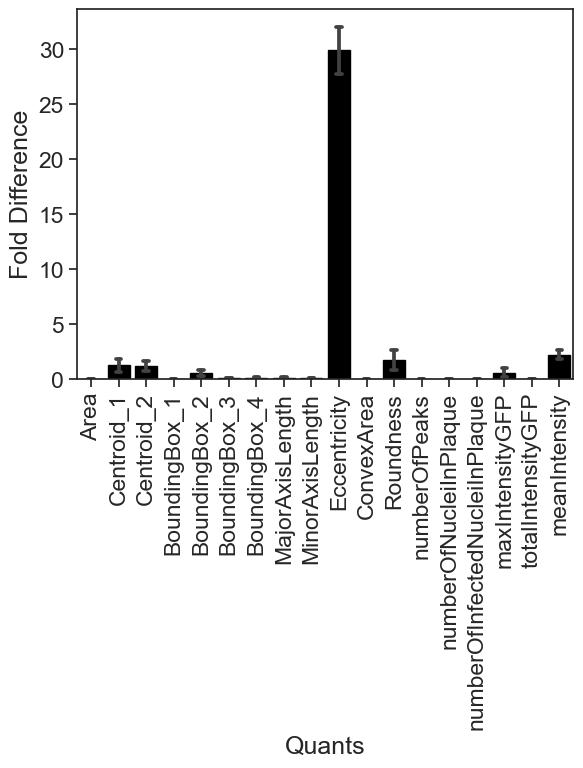

In [93]:
barplot_info_loss(diff_perc_df)


#### ROUGH WORK

NameError: name 'virus_params_w2' is not defined

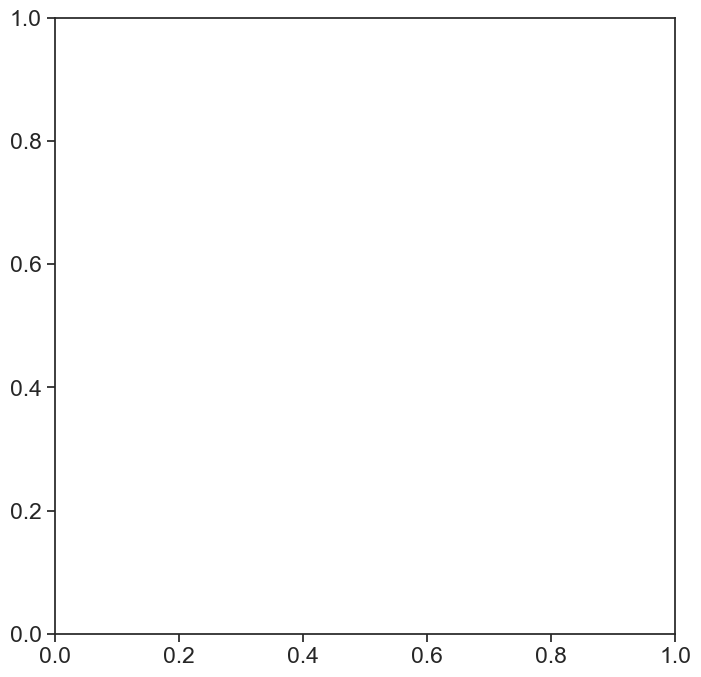

In [52]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(get_plaque_mask(TIFF.imread(os.path.join(exp.plate_folder,d,'2020-06-03','2072','200601-zplate-g2_J17_s1_w2.tif')),virus_params_w2)[0],cmap='gray')
plt.show()
